In [31]:

'''

1. Sentiment analysis- on the journal (understaing the pos/neg/neutral) then we will compare between cntx vs generic 

'''
import pandas as pd

df = pd.read_csv("journals_with_week_labels.csv")

# Make sure day is datetime
df['day'] = pd.to_datetime(df['day'])

# Sort
df = df.sort_values(['uid', 'day'])


#download pip install vaderSentiment- this analysis tool is a good one for journal data

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(t):
    if pd.isna(t):
        return 0
    return analyzer.polarity_scores(str(t))['compound']

df['sentiment'] = df['data'].apply(get_sentiment)

def week_type(w):
    if w <= 6:
        return 'contextual'
    elif w in [7, 8]:
        return 'generic'
    else:
        return 'extra week'

df['phase'] = df['week_per_uid'].apply(week_type)


'''
+1 = very positive

0 = neutral

–1 = very negative

'''

print(df[['uid', 'week_per_uid', 'phase', 'sentiment']].head())
df.to_csv("journal_sentimentScore.csv")

               uid  week_per_uid       phase  sentiment
0   t0002@sreflect             1  contextual     0.6997
3   t0002@sreflect             1  contextual     0.8720
19  t0002@sreflect             1  contextual     0.9517
20  t0002@sreflect             1  contextual    -0.8080
47  t0002@sreflect             1  contextual    -0.8899


In [32]:
#doing a t-test (per-entry)

#results: significant p-value <0.05
from scipy.stats import ttest_ind

t = ttest_ind(
    df[df['phase']=='contextual']['sentiment'],
    df[df['phase']=='generic']['sentiment'],
    equal_var=False
)
print(t)


TtestResult(statistic=-2.1114779743146, pvalue=0.03787793481080731, df=79.36234007728585)


In [33]:
#per user cntx vs generic (mean here)

user_phase = (
    df.groupby(['uid', 'phase'])['sentiment']
    .mean()
    .reset_index()
    .pivot(index='uid', columns='phase', values='sentiment')
)

user_phase['difference'] = user_phase['generic'] - user_phase['contextual']

print(user_phase.head(20))


phase           contextual  extra week   generic  difference
uid                                                         
t0002@sreflect    0.141775         NaN       NaN         NaN
t0003@sreflect    0.564107      0.8519  0.486733   -0.077374
t0004@sreflect    0.415682         NaN  0.555536    0.139854
t0005@sreflect    0.381926         NaN       NaN         NaN
t0006@sreflect    0.678067         NaN  0.730962    0.052895
t0007@sreflect    0.126654         NaN  0.356900    0.230246
t0008@sreflect    0.615992         NaN  0.684340    0.068348
t0009@sreflect    0.267240      0.1958  0.297244    0.030004
t0010@sreflect    0.513747         NaN  0.741320    0.227573
t0011@sreflect    0.351018         NaN -0.238200   -0.589218
t0012@sreflect    0.404267         NaN  0.493900    0.089633
t0013@sreflect    0.175000         NaN  0.933100    0.758100
t0014@sreflect    0.774487         NaN  0.771700   -0.002787
t0015@sreflect    0.551586         NaN  0.726400    0.174814
t0016@sreflect    0.5625

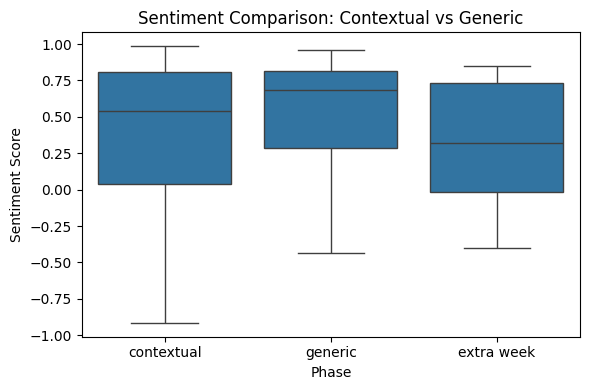

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='phase', y='sentiment')
plt.title("Sentiment Comparison: Contextual vs Generic")
plt.xlabel("Phase")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()


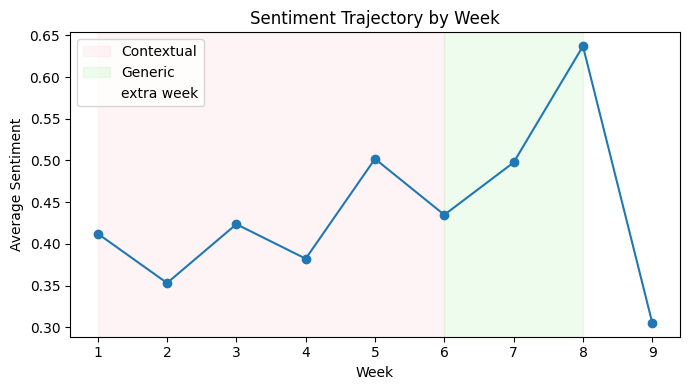

In [35]:
weekly_avg = (
    df.groupby('week_per_uid')['sentiment']
    .mean()
    .reset_index()
)

plt.figure(figsize=(7,4))
plt.plot(weekly_avg['week_per_uid'], weekly_avg['sentiment'], marker='o')
plt.axvspan(1,6, color='lightpink', alpha=0.15, label='Contextual')
plt.axvspan(5.99,8, color='lightgreen', alpha=0.15, label='Generic')
plt.axvspan(8.99,9, color='white', alpha=0.15, label='extra week')

plt.title("Sentiment Trajectory by Week")
plt.xlabel("Week")
plt.ylabel("Average Sentiment")
plt.legend()
plt.tight_layout()
plt.show()


In [47]:
'''
2. detecting emotional tone on the journal data using a different goemotions model and then comparing between 
cntx and generic

'''

import pandas as pd
from transformers import pipeline
import torch

# Initialize the GoEmotion model
# Using the original Google model
emotion_classifier = pipeline(
    "text-classification",
    model="SamLowe/roberta-base-go_emotions",
    top_k=None,  # Return all emotion scores
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

def analyze_journal_entry(text, top_n=5):
    """
    Analyze a single journal entry and return top emotions
    
    Args:
        text: Journal entry text
        top_n: Number of top emotions to return
    
    Returns:
        List of tuples (emotion, score)
    """
    results = emotion_classifier(text)[0]
    
    # Sort by score and get top N
    sorted_emotions = sorted(results, key=lambda x: x['score'], reverse=True)
    return [(e['label'], e['score']) for e in sorted_emotions[:top_n]]

def analyze_journal_dataset(df, text_column='entry', top_n=3):
    """
    Analyze entire dataset of journal entries
    
    Args:
        df: DataFrame with journal entries
        text_column: Name of column containing journal text
        top_n: Number of top emotions to extract per entry
    
    Returns:
        DataFrame with emotion analysis added
    """
    results = []
    
    for idx, row in df.iterrows():
        text = row[text_column]
        
        # Handle empty or very short entries
        if pd.isna(text) or len(str(text).strip()) < 3:
            results.append({
                'top_emotion': None,
                'top_emotion_score': None,
                'all_top_emotions': None
            })
            continue
        
        # Get emotion predictions
        emotions = analyze_journal_entry(str(text), top_n=top_n)
        
        results.append({
            'top_emotion': emotions[0][0] if emotions else None,
            'top_emotion_score': emotions[0][1] if emotions else None,
            'all_top_emotions': emotions
        })
        
        # Print progress
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1} entries...")
    
    # Add results to dataframe
    results_df = pd.DataFrame(results)
    df_analyzed = pd.concat([df, results_df], axis=1)
    
    return df_analyzed



Device set to use cpu


In [48]:
# Example usage
if __name__ == "__main__":
    # Example: Load your data
    
    df = pd.read_csv("journal_sentimentScore.csv")     
    
    print("Analyzing journal entries...")
    analyzed_df = analyze_journal_dataset(df, text_column='data', top_n=3)
    
    print("\nResults:")
    print(analyzed_df[['data', 'top_emotion', 'top_emotion_score']])
    
    # Save results
    # analyzed_df.to_csv('journal_entries_analyzed.csv', index=False)
    
    # Example: Analyze emotional trends over time
    print("\nEmotion distribution:")
    print(analyzed_df['top_emotion'].value_counts())

Analyzing journal entries...
Processed 10 entries...
Processed 20 entries...
Processed 30 entries...
Processed 40 entries...
Processed 50 entries...
Processed 60 entries...
Processed 70 entries...
Processed 80 entries...
Processed 90 entries...
Processed 100 entries...
Processed 110 entries...
Processed 120 entries...
Processed 130 entries...
Processed 140 entries...
Processed 150 entries...
Processed 160 entries...
Processed 170 entries...
Processed 180 entries...
Processed 190 entries...
Processed 200 entries...
Processed 210 entries...
Processed 220 entries...
Processed 230 entries...
Processed 240 entries...
Processed 250 entries...
Processed 260 entries...
Processed 270 entries...
Processed 280 entries...
Processed 290 entries...
Processed 300 entries...
Processed 310 entries...
Processed 320 entries...
Processed 330 entries...
Processed 340 entries...
Processed 350 entries...
Processed 360 entries...
Processed 370 entries...
Processed 380 entries...
Processed 390 entries...
Proce

In [49]:
analyzed_df.to_csv("journal_emotion.csv")

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

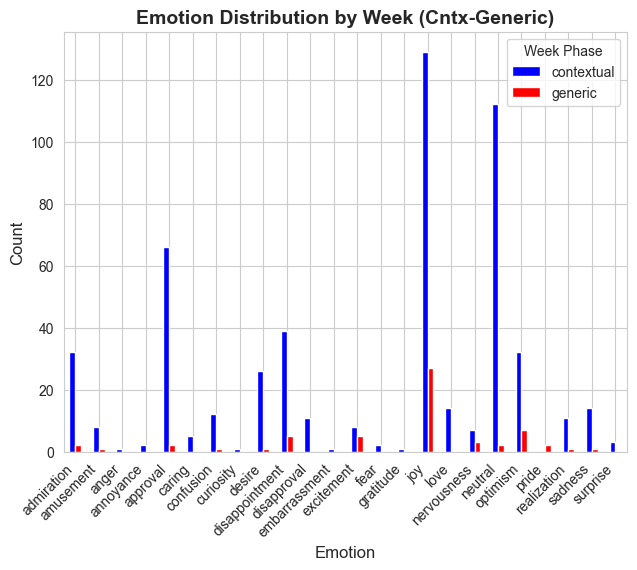

In [68]:
#graph visualization of emotional word count on journals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_clean = pd.read_csv("journal_emotion.csv")
df_clean = df_clean[~df_clean['phase'].str.contains('extra week', na=False)]



fig = plt.figure(figsize=(16, 12))

# 1. Side-by-side bar chart
ax1 = plt.subplot(2, 2, 1)
emotion_counts = pd.crosstab(df_clean['top_emotion'], df_clean['phase'])
emotion_counts.plot(kind='bar', ax=ax1, color=['blue','red',])
ax1.set_title('Emotion Distribution by Week (Cntx-Generic)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.legend(title='Week Phase', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

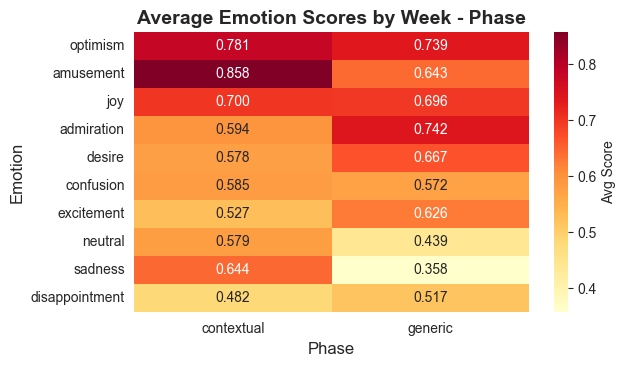

In [70]:

#heat map on avg emotion score by week phase

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_clean = pd.read_csv("journal_emotion.csv")
df_clean = df_clean[~df_clean['phase'].str.contains('extra week', na=False)]


ax4 = plt.subplot(2, 2, 4)
    
# Create a pivot table for heatmap
if 'top_emotion_score' in df_clean.columns:
    heatmap_data = df_clean.groupby([phase_column, emotion_column])['top_emotion_score'].mean().unstack(fill_value=0)
    # Select top emotions for readability
    top_cols = heatmap_data.sum(axis=0).nlargest(10).index
    heatmap_data = heatmap_data[top_cols]
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='YlOrRd', 
                ax=ax4, cbar_kws={'label': 'Avg Score'})
    ax4.set_title('Average Emotion Scores by Week - Phase', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Phase', fontsize=12)
    ax4.set_ylabel('Emotion', fontsize=12)

plt.show()

In [73]:
#stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, norm


In [74]:
df_clean = pd.read_csv("journal_emotion.csv")

# remove extra-week rows
df_clean = df_clean[~df_clean['phase'].str.contains('extra week', na=False)]

# drop rows with missing emotion
df_clean = df_clean[df_clean['top_emotion'].notna()]


In [77]:
def statistical_analysis(df, phase_column='phase', emotion_column='top_emotion'):
    """
    Perform statistical tests to compare emotion distributions between phases
    """
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS: Contextual vs Generic")
    print("="*70)
    
    df_local = df[df[emotion_column].notna()].copy()
    
    # Contingency table
    contingency_table = pd.crosstab(df_local[emotion_column], df_local[phase_column])
    
    print("\nContingency Table:")
    print(contingency_table)
    print(f"\nTotal entries: {len(df_local)}")
    print(f"  - Contextual: {(df_local[phase_column] == 'contextual').sum()}")
    print(f"  - Generic: {(df_local[phase_column] == 'generic').sum()}")
    
    # Chi-square test
    print("\n" + "-"*70)
    print("1. CHI-SQUARE TEST (Overall emotion distribution difference)")
    print("-"*70)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.001:
        print("Result: HIGHLY SIGNIFICANT difference (p < 0.001) ***")
    elif p_value < 0.01:
        print("Result: SIGNIFICANT difference (p < 0.01) **")
    elif p_value < 0.05:
        print("Result: SIGNIFICANT difference (p < 0.05) *")
    else:
        print("Result: NO significant difference (p >= 0.05)")
    
    # Cramér's V
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    print(f"Cramér's V (effect size): {cramers_v:.4f}")
    
    if cramers_v < 0.1:
        print("  Small effect size")
    elif cramers_v < 0.3:
        print(" Medium effect size")
    else:
        print(" Large effect size")
    
    # Individual emotions
    print("\n" + "-"*70)
    print("2. INDIVIDUAL EMOTION COMPARISONS")
    print("-"*70)
    print("\nTesting if each emotion appears more in one phase than the other:\n")
    
    significant_emotions = []
    
    contextual_total = (df_local[phase_column] == 'contextual').sum()
    generic_total = (df_local[phase_column] == 'generic').sum()
    
    for emotion in contingency_table.index:
        contextual_count = contingency_table.loc[emotion, 'contextual']
        generic_count = contingency_table.loc[emotion, 'generic']
        
        contextual_prop = contextual_count / contextual_total if contextual_total > 0 else 0
        generic_prop = generic_count / generic_total if generic_total > 0 else 0
        
        diff = contextual_prop - generic_prop
        
        if contextual_count + generic_count >= 5:
            p_pooled = (contextual_count + generic_count) / (contextual_total + generic_total)
            se = np.sqrt(p_pooled * (1 - p_pooled) * (1/contextual_total + 1/generic_total))
            z_stat = diff / se if se > 0 else 0
            p_val = 2 * (1 - norm.cdf(abs(z_stat)))
            
            sig_marker = ""
            if p_val < 0.001:
                sig_marker = "***"
            elif p_val < 0.01:
                sig_marker = "**"
            elif p_val < 0.05:
                sig_marker = "*"
            
            if sig_marker:
                significant_emotions.append((emotion, diff, p_val))
            
            print(f"{emotion:20s} | Contextual: {contextual_prop:5.1%} | Generic: {generic_prop:5.1%} | "
                  f"Diff: {diff:+6.1%} | p={p_val:.4f} {sig_marker}")
    
    if significant_emotions:
        print("\n" + "-"*70)
        print("3. SIGNIFICANT DIFFERENCES SUMMARY")
        print("-"*70)
        for emotion, diff, p_val in sorted(significant_emotions, key=lambda x: x[2]):
            direction = "MORE in Contextual" if diff > 0 else "MORE in Generic"
            print(f"{emotion:20s} | {direction:20s} | Difference: {diff:+6.1%} | p={p_val:.4f}")
    else:
        print("\nNo significant differences found for individual emotions.")
    
    print("\n" + "="*70)
    
    return {
        'chi2': chi2,
        'p_value': p_value,
        'cramers_v': cramers_v,
        'contingency_table': contingency_table,
        'significant_emotions': significant_emotions
    }


In [78]:
results = statistical_analysis(df_clean)



STATISTICAL ANALYSIS: Contextual vs Generic

Contingency Table:
phase           contextual  generic
top_emotion                        
admiration              32        2
amusement                8        1
anger                    1        0
annoyance                2        0
approval                66        2
caring                   5        0
confusion               12        1
curiosity                1        0
desire                  26        1
disappointment          39        5
disapproval             11        0
embarrassment            1        0
excitement               8        5
fear                     2        0
gratitude                1        0
joy                    129       27
love                    14        0
nervousness              7        3
neutral                112        2
optimism                32        7
pride                    0        2
realization             11        1
sadness                 14        1
surprise                 3        0

In [81]:
'''
3. behavior intention extraction: best approach is rule based patterns and then embeddings -> combine both 
'''


import re
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# -----------------------------
# Load data + model
# -----------------------------
df = pd.read_csv("journal_emotion.csv")
model = SentenceTransformer("all-MiniLM-L6-v2")

# -----------------------------
# Rule-based patterns
# -----------------------------
patterns = {
    "intention": r"\b(I want to|I plan to|I hope to|I need to|I intend to|I should|goal is)\b",
    "behavior_change": r"\b(I'm going to|I will start|I will stop|I'm trying to|working on)\b",
    "planning": r"\b(tomorrow I|next week|my plan is|I'm planning to)\b",
    "reflection": r"\b(I realized|I noticed|upon reflection|looking back)\b",
    "rumination": r"\b(I keep thinking|can't stop thinking|I feel stuck|I'm avoiding)\b",
}

# -----------------------------
# Helper: rule-based detection
# -----------------------------
def detect_rule_based(text):
    tags = []
    for label, ptn in patterns.items():
        if re.search(ptn, text, re.IGNORECASE):
            tags.append(label)
    return tags

# -----------------------------
# Embedding exemplars
# -----------------------------
exemplars = {
    "intention": [
        "I want to improve my habits.",
        "I hope to make a change.",
        "I need to work on myself.",
    ],
    "behavior_change": [
        "I will try to change my behavior.",
        "I am working towards forming better habits.",
    ],
    "planning": [
        "My plan is to complete tasks tomorrow.",
        "Tomorrow I will do something productive.",
    ],
    "reflection": [
        "I realized something about myself.",
        "I noticed a pattern in my behavior.",
    ],
    "rumination": [
        "I keep overthinking.",
        "I can't stop cycling through thoughts.",
    ],
    "reflective": [
        "I learned something about myself.",
        "I understand why I felt this way.",
    ],
    "descriptive": [
        "This is what happened today.",
        "I went to class and then ate lunch.",
    ],
    "actionable": [
        "I will do this specific task.",
        "I have a concrete plan.",
    ],
    "emotional_venting": [
        "I feel overwhelmed and upset.",
        "I'm so stressed and frustrated.",
    ],
    "problem_solving": [
        "I think I can solve this by doing something.",
        "I tried to find a solution.",
    ]
}

# Pre-embed exemplars
embeds = {k: model.encode(v, convert_to_tensor=True) for k, v in exemplars.items()}

# -----------------------------
# Helper: embedding detection
# -----------------------------
def detect_embeddings(text, threshold=0.50):
    results = []
    text_embed = model.encode([text], convert_to_tensor=True)

    for label, ex_embed in embeds.items():
        sim = util.cos_sim(text_embed, ex_embed).max().item()
        if sim >= threshold:
            results.append(label)

    return results

# -----------------------------
# Apply both methods
# -----------------------------
all_behavior_labels = []
all_actionability_labels = []

for t in df["data"]:
    rule_tags = detect_rule_based(t)
    embed_tags = detect_embeddings(t)
    combined = set(rule_tags + embed_tags)

    # separate behavior categories and actionability categories
    behavior = [c for c in combined if c in patterns.keys()]
    action_type = [c for c in combined
                   if c in ["reflective", "descriptive", "actionable", "emotional_venting", "problem_solving"]]

    all_behavior_labels.append(",".join(behavior))
    all_actionability_labels.append(",".join(action_type))

df["behavior_tags"] = all_behavior_labels
df["actionability"] = all_actionability_labels

df.to_csv("journal_behavior_intention_labeled.csv", index=False)
print("Done.")



Done.


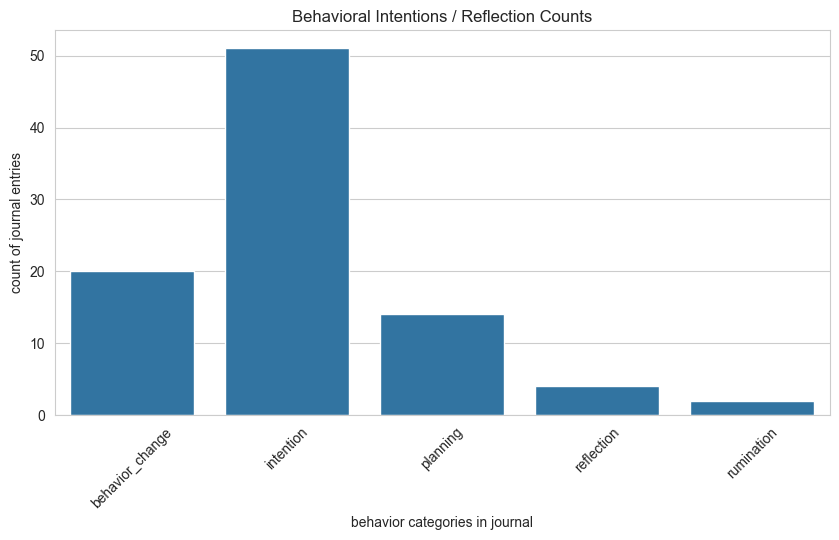

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

df_tags = df["behavior_tags"].str.get_dummies(sep=",")
df_act = df["actionability"].str.get_dummies(sep=",")

plt.figure(figsize=(10,5))
sns.barplot(x=df_tags.sum().index, y=df_tags.sum().values)
plt.title("Behavioral Intentions / Reflection Counts")
plt.xlabel("behavior categories in journal")
plt.ylabel("count of journal entries")
plt.xticks(rotation=45)
plt.show()


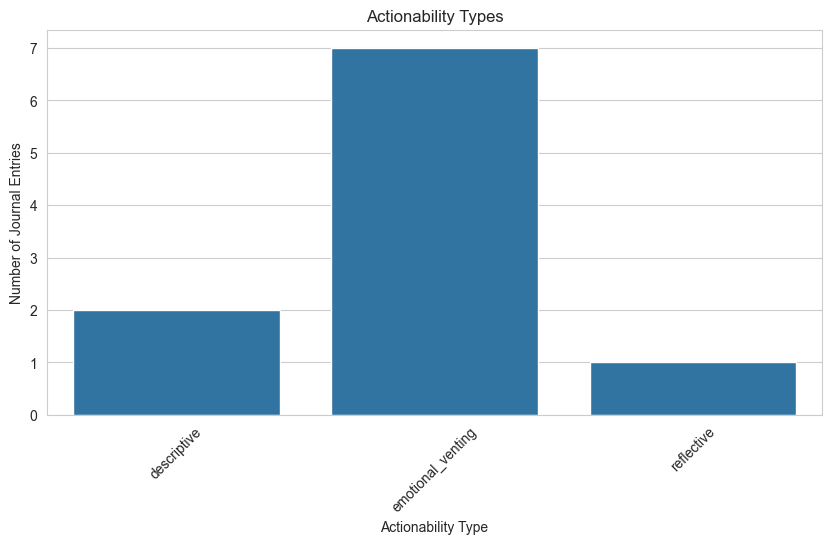

In [87]:
plt.figure(figsize=(10,5))
sns.barplot(x=df_act.sum().index, y=df_act.sum().values)
plt.title("Actionability Types")
plt.xlabel("Actionability Type")
plt.ylabel("Number of Journal Entries")
plt.xticks(rotation=45)
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nadiamehjabin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Index(['Unnamed: 0', 'data', 'day', 'uid', 'week_per_uid'], dtype='object')
          day  dayofweek  is_weekend
0  2024-02-01          3       False
1  2024-02-01          3       False
2  2024-02-02          4       False
3  2024-02-02          4       False
4  2024-02-02          4       False
5  2024-02-02          4       False
6  2024-02-02          4       False
7  2024-02-02          4       False
8  2024-02-02          4       False
9  2024-02-03          5        True
10 2024-02-03          5        True
11 2024-02-03          5        True
12 2024-02-03          5        True
13 2024-02-03          5        True
14 2024-02-03          5        True
15 2024-02-04          6        True
16 2024-02-04          6        True
17 2024-02-04          6        True
18 2024-02-04          6        True
19 2024-02-04          6        True
20 2024-02-05          0       False
21 2024-02-05          0       False
22 2024-02-05          0       False
23 2024-02-05          0       False

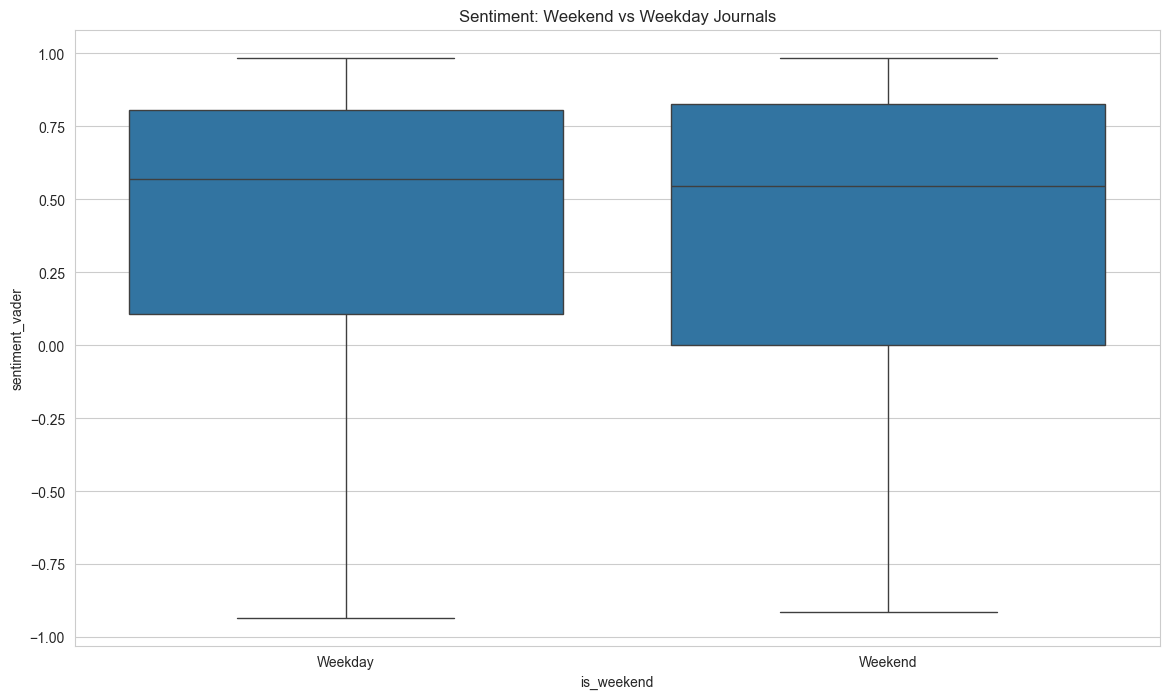

In [89]:
'''
5. Weekend vs weekday sentiment journal analysis
'''

#look into weekend journals
#question: weekend and weekday sentiment differe meaningfully
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('vader_lexicon')

# 1. Load CSV FIRST
df = pd.read_csv("journals_with_week_labels.csv")
print(df.columns)

# 2. Compute sentiment
sia = SentimentIntensityAnalyzer()
df['sentiment_vader'] = df['data'].astype(str).apply(
    lambda x: sia.polarity_scores(x)['compound']
)

# 3. Weekend flag
df['day'] = pd.to_datetime(df['day'])
df['dayofweek'] = df['day'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6])
print(
    df[['day', 'dayofweek', 'is_weekend']].head(40)
)
# 4. Extract groups
weekend = df[df['is_weekend']]['sentiment_vader']
weekday = df[~df['is_weekend']]['sentiment_vader']

# 5. T-test
t, p = stats.ttest_ind(weekend, weekday, equal_var=False)
print("Sentiment Weekend vs Weekday: T=", round(t,3), "p=", round(p,5))

# 6. Plot
sns.boxplot(data=df, x='is_weekend', y='sentiment_vader')
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title("Sentiment: Weekend vs Weekday Journals")
plt.show()











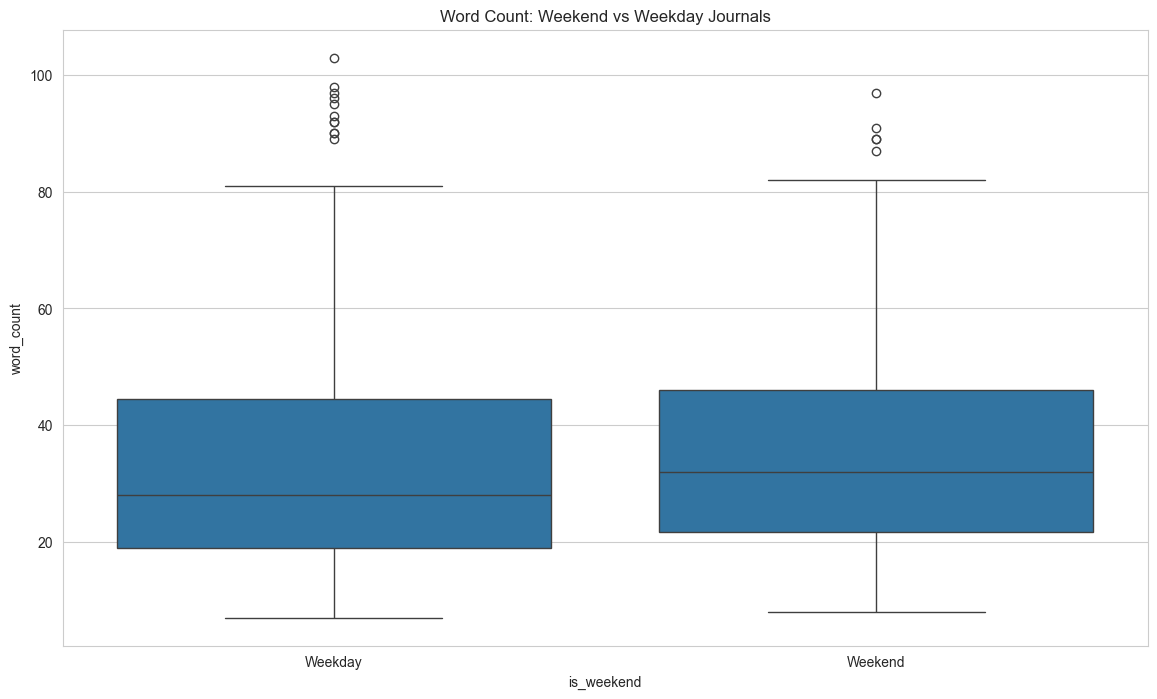

Word Count T= 1.513 p= 0.13124


In [91]:
# Word count
df['word_count'] = df['data'].astype(str).apply(lambda x: len(x.split()))

sns.boxplot(data=df, x='is_weekend', y='word_count')
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title("Word Count: Weekend vs Weekday Journals")
plt.show()

# t-test
t, p = stats.ttest_ind(df[df['is_weekend']]['word_count'],
                       df[~df['is_weekend']]['word_count'], equal_var=False)
print("Word Count T=", round(t,3), "p=", round(p,5))


In [92]:
for comp in ['neg','neu','pos']:
    df[comp] = df['data'].astype(str).apply(lambda x: sia.polarity_scores(x)[comp])

    weekend_vals = df[df['is_weekend']][comp]
    weekday_vals = df[~df['is_weekend']][comp]

    t, p = stats.ttest_ind(weekend_vals, weekday_vals, equal_var=False)
    print(f"{comp.upper()} diff: T={t:.3f}, p={p:.5f}")


NEG diff: T=0.855, p=0.39315
NEU diff: T=-1.028, p=0.30466
POS diff: T=0.538, p=0.59091


In [93]:
import re
from collections import Counter

def top_words(series, n=15):
    words = re.findall(r"[A-Za-z']+", " ".join(series).lower())
    stop = set(["the","a","an","and","or","to","of","in","for",
                "on","with","at","from","by","is","are","am",
                "was","were","be","been","being","i","me","my",
                "we","us","our","you","your"])  # quick stoplist
    words = [w for w in words if w not in stop and len(w)>3]
    return Counter(words).most_common(n)

print("Weekday top words:", top_words(df[~df['is_weekend']]['data']))
print("Weekend top words:", top_words(df[df['is_weekend']]['data']))


Weekday top words: [('more', 167), ('that', 160), ('have', 141), ('today', 103), ('time', 98), ("it's", 86), ('think', 83), ('people', 83), ('feel', 82), ('good', 80), ("i've", 79), ('work', 76), ('this', 72), ('just', 64), ('some', 64)]
Weekend top words: [('that', 71), ('time', 60), ('more', 59), ('this', 58), ('have', 51), ('about', 44), ('week', 42), ('think', 35), ('good', 34), ('people', 33), ('some', 29), ('today', 29), ("i've", 28), ('also', 27), ('feel', 27)]


In [95]:
# df['hour'] = df['day'].dt.hour
# sns.histplot(data=df, x='hour', hue='is_weekend', kde=True, bins=24)
# plt.title("Hour of Journaling: Weekday vs Weekend")
# plt.show()


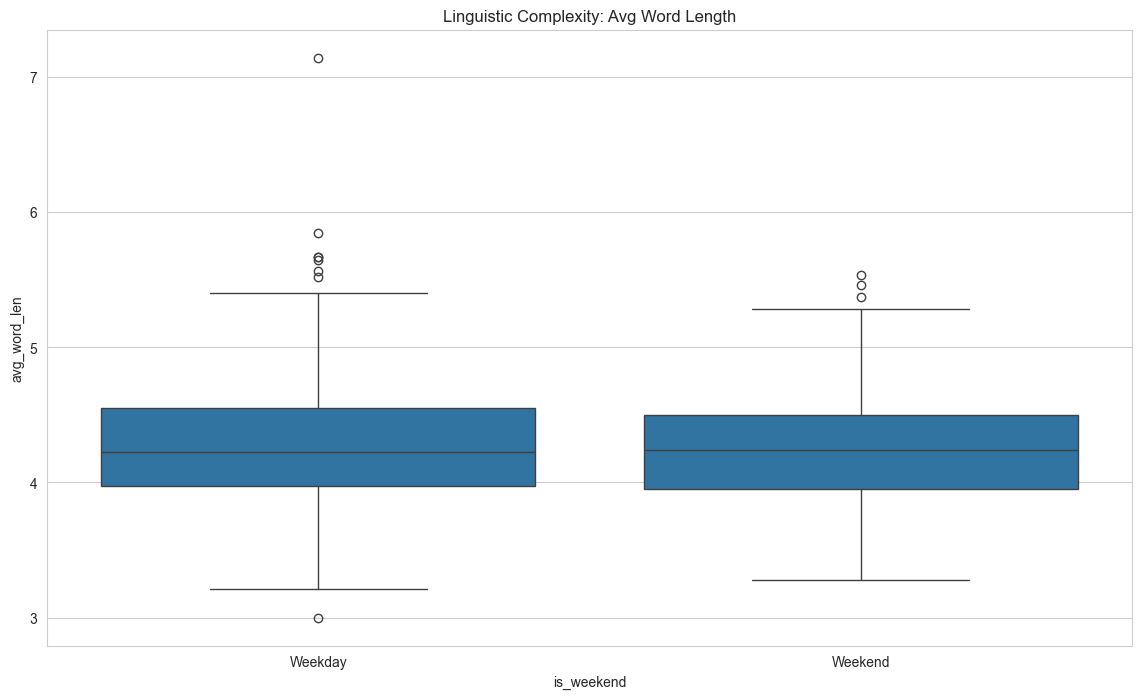

In [96]:
df['char_count'] = df['data'].str.len()
df['avg_word_len'] = df['data'].astype(str).apply(
    lambda x: sum(len(w) for w in x.split()) / (len(x.split())+1e-9)
)

sns.boxplot(data=df, x='is_weekend', y='avg_word_len')
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.title("Linguistic Complexity: Avg Word Length")
plt.show()


In [97]:
df['very_negative'] = df['sentiment_vader'] < -0.5
df['very_positive'] = df['sentiment_vader'] > 0.5

print(df.groupby('is_weekend')['very_negative'].mean())
print(df.groupby('is_weekend')['very_positive'].mean())


is_weekend
False    0.048724
True     0.063953
Name: very_negative, dtype: float64
is_weekend
False    0.542923
True     0.529070
Name: very_positive, dtype: float64


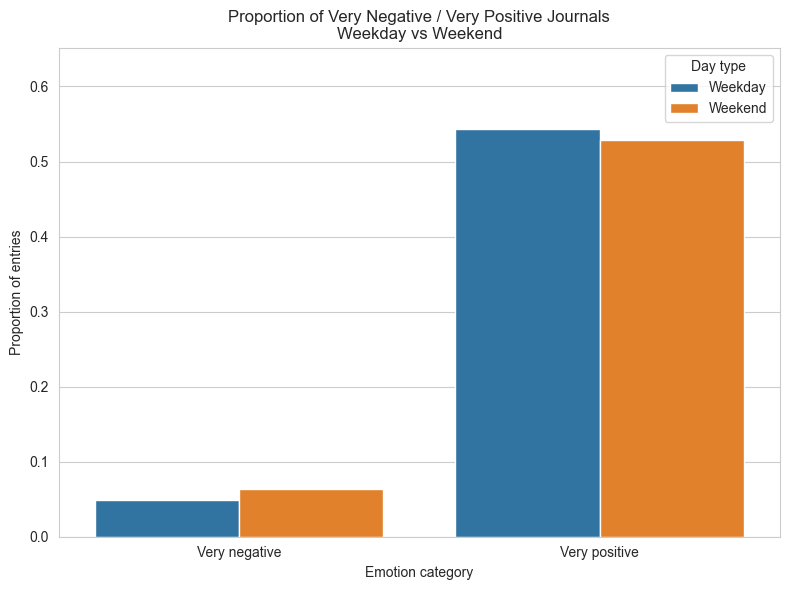

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Compute proportions
very_neg = df.groupby('is_weekend')['very_negative'].mean().reset_index()
very_pos = df.groupby('is_weekend')['very_positive'].mean().reset_index()

# 2. Add a label and standardize the column name
very_neg['type'] = 'Very negative'
very_pos['type'] = 'Very positive'

very_neg = very_neg.rename(columns={'very_negative': 'proportion'})
very_pos = very_pos.rename(columns={'very_positive': 'proportion'})

# 3. Combine into one dataframe
plot_df = pd.concat([very_neg, very_pos], ignore_index=True)

# 4. Make is_weekend readable
plot_df['is_weekend'] = plot_df['is_weekend'].map({False: 'Weekday', True: 'Weekend'})

# 5. Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=plot_df, x='type', y='proportion', hue='is_weekend')
plt.title("Proportion of Very Negative / Very Positive Journals\nWeekday vs Weekend")
plt.ylabel("Proportion of entries")
plt.xlabel("Emotion category")
plt.ylim(0, plot_df['proportion'].max() * 1.2)
plt.legend(title="Day type")
plt.tight_layout()
plt.show()
